# Solver

The evolution of quantum mechanical systems is described by differential
equations like Schroedinger's equation and the `Solver` class and derived
classes simulate these systems by solving the corresponding equation. They
are the backbone of simulations in `qopt`.
(In later sections, we will extend this procedure to stochastic differential
equations and a master equation in Lindblad form, and discuss the
corresponding solver classes.)


The class `SchroedingerSolver` computes the solution to Schroedinger's equation and is
therefore used to describe basic quantum systems in the absence of noise.
The equation is given as:


\begin{equation}
i \hbar \partial_t \psi(t) = H(t) \psi(t)
\end{equation}

for any wavefunction $\psi(t)$ and a time depended Hamiltonian $H(t)$.
Lets set $\hbar = 1$ for simplicity.
Then split the Hamilton operator in a drift and a control part

\begin{align*}
H(t) = H_d(t) + H_c(t),
\end{align*}

where the latter can be written as sum weighted by control amplitudes

\begin{align*}
H_c(t) = \sum_n u_n(t) B_n.
\end{align*}

The drift Hamiltonian describes dynamics that we know about but cannot control,
while the control Hamiltonian describes the contributions which can be changed
dynamically to manipulate the qubit.

As a simple example, we consider a single qubit under Rabi-driving
in the rotating frame.
Its Hamiltonian with XY-control has the simple form:

\begin{align*}
H = \delta_\omega(t) \sigma_z / 2 + A_x(t) \sigma_x / 2
+ A_y(t) \sigma_y / 2
\end{align*}

where $\delta_\omega$ is the frequency detuning and $A_x$ and $A_y$ the
driving amplitudes. (A derivation is given in the examples section of the
documentation.)
Then we can split the Hamilton operator:

\begin{align*}
H_c(t) &= A_x(t) \sigma_x / 2 + A_y(t) \sigma_y / 2 \\
u_1(t)&=A_x(t) \\
u_2(t)&=A_y(t) \\
B_1&=\sigma_x / 2 \\
B_2&=\sigma_y / 2 \\
H_d(t) &= \delta_\omega(t) \sigma_z / 2
\end{align*}

We implement this hamiltonian in qopt by using the dense operator class, which
encapsulates the representation of a matrix with the functionalities of an
operator such as taking the hermitian conjugate, the trace, or calculating
the spectral decomposition.

In [1]:
import numpy as np

from qopt.matrix import DenseOperator

sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()

For computational feasibility, we make the assumption of
piece wise constant control and initialize the time steps. (In general they
do not need to be equidistant.)

In [2]:
n_time_steps = 5
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

The control Hamiltonian is given as list of operators and has an entry for each
term in the control Hamiltonian. The drift Hamiltonian can either be an empty
list, if the system does not have any drift dynamics, or a list with an entry
for each time step, or a list with a single operator. In the last case this
operator will be used for every time step.

In [3]:
delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]



By setting $\delta_\omega$ to zero, we require the driving to be
exactly resonant.
Then set the control amplitudes to values resulting in an $X_\pi$-Rotation.

In [4]:
control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

Then we initialize a solver for Schroedinger's equation, for the Hamiltonian defined above
and set the optimization parameters to the Hamiltonian.

In [5]:
import matplotlib.pyplot as plt
from qopt import *
solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(control_amplitudes)

The equation is solved automatically, when we access the propagators.
The propagators for each time step can be requested with the property
`Solver.propagators`.

In [6]:
solver.propagators


[DenseOperator with data: 
 array([[0.95105652+0.j        , 0.        -0.30901699j],
        [0.        -0.30901699j, 0.95105652+0.j        ]]),
 DenseOperator with data: 
 array([[0.95105652+0.j        , 0.        -0.30901699j],
        [0.        -0.30901699j, 0.95105652+0.j        ]]),
 DenseOperator with data: 
 array([[0.95105652+0.j        , 0.        -0.30901699j],
        [0.        -0.30901699j, 0.95105652+0.j        ]]),
 DenseOperator with data: 
 array([[0.95105652+0.j        , 0.        -0.30901699j],
        [0.        -0.30901699j, 0.95105652+0.j        ]]),
 DenseOperator with data: 
 array([[0.95105652+0.j        , 0.        -0.30901699j],
        [0.        -0.30901699j, 0.95105652+0.j        ]])]

Furthermore, the total time evolution is calculated in the
property `Solver.forward_propagators` and a backward pass
for the efficient calculation of derivatives as presented
in the GRAPE alogrithm can be accessed by the property
`Solver.reversed_propagators`.

In [7]:
print('Total unitary of the evolution: ')
print(solver.forward_propagators[-1].data)

Total unitary of the evolution: 
[[0.0000000e+00+0.j 0.0000000e+00-1.j]
 [0.0000000e+00-1.j 4.4408921e-16+0.j]]


For visualization, we can also plot the resulting trace on the
Bloch sphere:

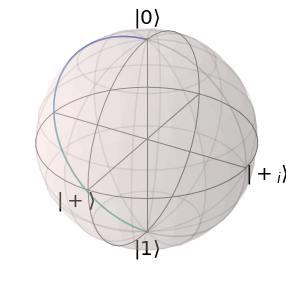

In [8]:
solver.plot_bloch_sphere()
plt.show()

We can also use a plotting function from `qopt.plotting` to
consider another initial state:


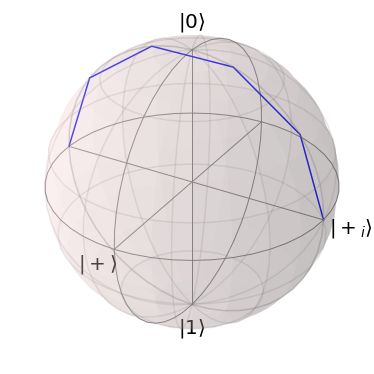

In [9]:
initial_state=(1 / np.sqrt(2)) * DenseOperator(np.asarray([[1], [1j]]))
plot_bloch_vector_evolution(
    forward_propagators=solver.forward_propagators,
    initial_state=initial_state
)


This plotting function plots the actual propagators as calculated by
the `Solver`. The method `Solver.plot_bloch_sphere` oversamples the
pulse for a smoother plot.

We can also define an initial state in the `Solver` class.

In [10]:
solver_initial_state = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps,
    initial_state=(1 / np.sqrt(2)) * DenseOperator(np.asarray([[1], [1j]]))
)
solver_initial_state.set_optimization_parameters(control_amplitudes)

Now the property `Solver.forward_propagators` contains the propagated initial
state.

In [11]:
solver_initial_state.forward_propagators

[DenseOperator with data: 
 array([[0.70710678+0.j        ],
        [0.        +0.70710678j]]),
 DenseOperator with data: 
 array([[0.89100652+0.j       ],
        [0.        +0.4539905j]]),
 DenseOperator with data: 
 array([[0.98768834+0.j        ],
        [0.        +0.15643447j]]),
 DenseOperator with data: 
 array([[0.98768834+0.j        ],
        [0.        -0.15643447j]]),
 DenseOperator with data: 
 array([[0.89100652+0.j       ],
        [0.        -0.4539905j]]),
 DenseOperator with data: 
 array([[0.70710678+0.j        ],
        [0.        -0.70710678j]])]